<a href="https://colab.research.google.com/github/younhuiji/openCV/blob/main/%5B3%5DU_NET%E1%84%92%E1%85%AA%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 01 :  임포트  

In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import tensorflow.python.keras.backend as k


### Step 02 :  이미지 , 마스크 배열로 리턴

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1


#데이터 경로 지정
TRAIN_PATH = '/content/drive/MyDrive/저녁ICT/day19/sm_data/train/'
TEST_PATH = '/content/drive/MyDrive/저녁ICT/day19/sm_data/test/'

# UserWarning을 무시하는 설정(없음 OK)
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

#이미지 파일명을 리스트 형식으로 리턴
train_imgs = glob.glob(TRAIN_PATH+'org/*.png')
train_masks = glob.glob(TRAIN_PATH+'label/*.png')
test_imgs = glob.glob(TEST_PATH+'org/*.png')
test_masks = glob.glob(TEST_PATH+'label/*.png')

#리스트 길이 리턴
num_of_train_imgs = len(train_imgs)
num_of_train_masks = len(train_masks)
if num_of_train_imgs != num_of_train_masks:
    print('invalid datasets, please check train data')


#각이미지를 배열로 리턴
#image
X_train = np.zeros((num_of_train_imgs, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# mask
Y_train = np.zeros((num_of_train_masks, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n in range(num_of_train_imgs):
    X_train[n] = imread(train_imgs[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    Y_train[n] = imread(train_masks[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


# 테스트 이미지를 배열로 리턴
X_test = np.zeros((len(test_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_masks), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting test images ... ')
sys.stdout.flush()

for n in range(len(test_imgs)):
    X_test[n] = imread(test_imgs[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    Y_test[n] = imread(test_masks[n],as_gray=True).reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print('Preparing is Done!')


Getting and resizing train images and masks ... 
Getting test images ... 
Preparing is Done!


### step03 이미지 확인

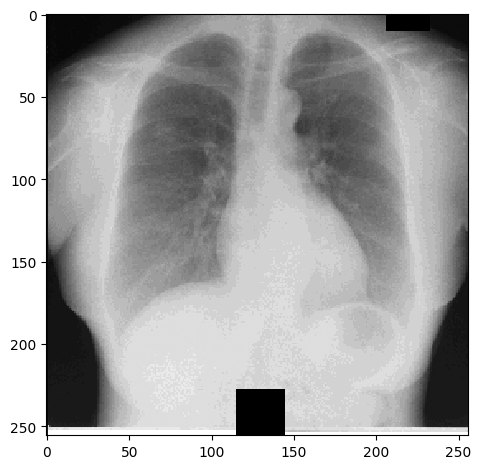

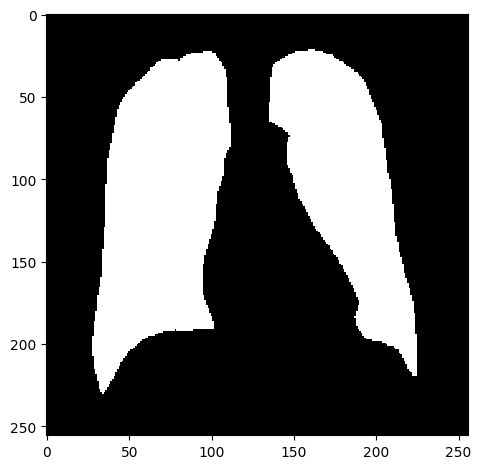

In [ ]:
###이미지 확인 #####
ix = random.randint(0, len(train_imgs))

imshow(X_train[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(np.squeeze(Y_train[ix].reshape(IMG_HEIGHT, IMG_WIDTH)))
plt.show()

### step 04  U-NET model

In [ ]:
# U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255.) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization() (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (p1)
c2 = LeakyReLU()(c2)
c2 = BatchNormalization() (c2)
c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c2)
c2 = LeakyReLU()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (p2)
c3 = LeakyReLU()(c3)
c3 = BatchNormalization() (c3)
c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c3)
c3 = LeakyReLU()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (p3)
c4 = LeakyReLU()(c4)
c4 = BatchNormalization() (c4)
c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c4)
c4 = LeakyReLU()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Conv2D(256, (3, 3), activation='elu',kernel_initializer='he_normal', padding='same') (c5)

##############################################################
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (u6)
c6 = LeakyReLU()(c6)
c6 = BatchNormalization() (c6)
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c6)
c6 = LeakyReLU()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (u7)
c7 = LeakyReLU()(c7)
c7 = BatchNormalization() (c7)
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c7)
c7 = LeakyReLU()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (u8)
c8 = LeakyReLU()(c8)
c8 = BatchNormalization() (c8)
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c8)
c8 = LeakyReLU()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization(momentum=0.9) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

### step 05 : 컴파일 모델 확인

In [ ]:
model.compile(optimizer=Nadam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['binary_accuracy','acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['lambda[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                               

### step 06 :  모델 학습

In [ ]:
checkpointer = ModelCheckpoint('model-u-net.h5', verbose=1, save_best_only=True)
reduceLr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=7)

results = model.fit(X_train,
                    Y_train,
                    validation_split=0.1,
                    batch_size=3,
                    epochs=50,
                    callbacks=[reduceLr, checkpointer])


Epoch 1/50
14/15 [===========================>..] - ETA: 0s - loss: -16.3552 - binary_accuracy: 0.2025 - acc: 0.2025
Epoch 1: val_loss improved from inf to 19.78393, saving model to model-u-net.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 35s 228ms/step - loss: -17.9107 - binary_accuracy: 0.2041 - acc: 0.2041 - val_loss: 19.7839 - val_binary_accuracy: 0.4694 - val_acc: 0.4694 - lr: 2.0000e-05
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: -46.4727 - binary_accuracy: 0.2341 - acc: 0.2341
Epoch 2: val_loss did not improve from 19.78393
15/15 [==============================] - 1s 44ms/step - loss: -46.4727 - binary_accuracy: 0.2341 - acc: 0.2341 - val_loss: 22.2707 - val_binary_accuracy: 0.4891 - val_acc: 0.4891 - lr: 2.0000e-05
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: -77.4979 - binary_accuracy: 0.2677 - acc: 0.2677
Epoch 3: val_loss improved from 19.78393 to 18.19681, saving model to model-u-net.h5
15/15 [==============================] - 1s 65ms/step - loss: -77.4979 - binary_accuracy: 0.2677 - acc: 0.2677 - val_loss: 18.1968 - val_binary_accuracy: 0.5524 - val_acc: 0.5524 - lr: 2.0000e-05
Epoch 4/50
15/15 [=========================

### step 07: 학습 후 테스트 데이터로 예측 결과 확인

1/1 [==============================] - 2s 2s/step


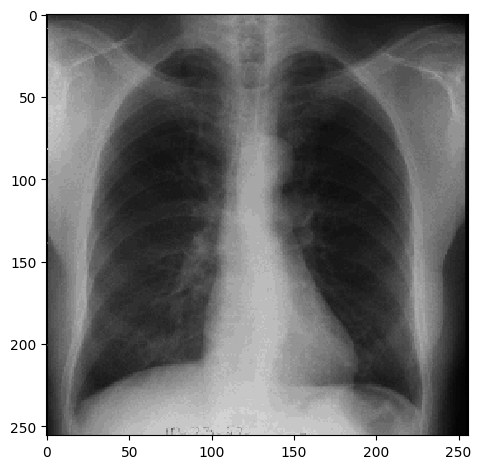

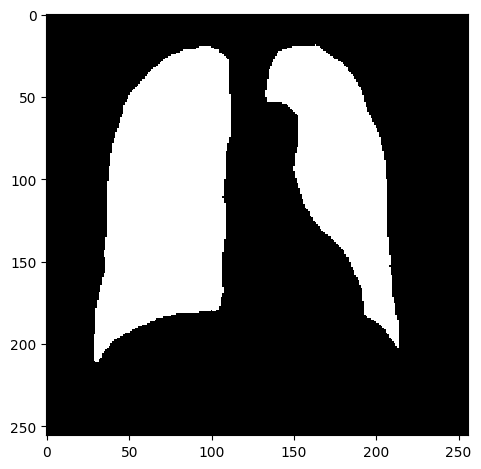

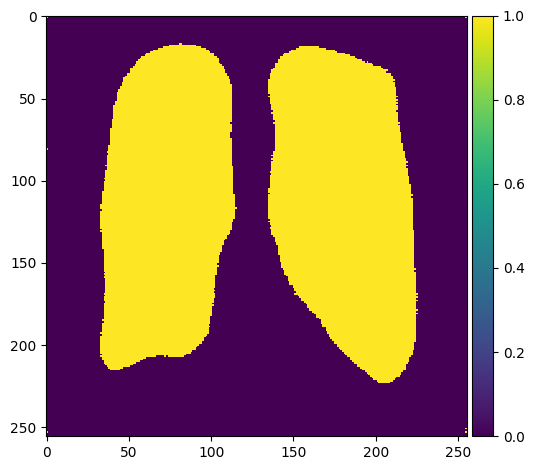

In [ ]:

model = load_model('model-u-net.h5')
preds_test = model.predict(X_test, verbose=1)

#픽셀  평가 결과를 0.5의 임계치로 0 or 255로 변환(평가 결과를 바이너리 이미지로 변환).
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# 임의 결과로 하나를 리턴 받아 표시
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(Y_test[ix].reshape(IMG_HEIGHT, IMG_WIDTH))
plt.show()
imshow(np.squeeze(preds_test_t[ix].reshape(IMG_HEIGHT, IMG_WIDTH)))
plt.show()